# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import xgboost as xgb


import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
filtered_data = pd.read_csv('drive/My Drive/amazon_reviews.csv')

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 11)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 11)


1    307061
0     57110
Name: Score, dtype: int64

In [0]:
final= final[:100000]

In [0]:
X = final['Text']
y = final['Score']

In [0]:
# Splitting file to train and test set
X_train = X[:70000]
X_test = X[70000:]
y_train = y[:70000]
y_test = y[70000:]

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

In [0]:
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
## Zero Padding in the beginning to make all sequences of same length
max_review_length = 600

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_test.shape)
print(X_train[1])

(70000, 600)
(30000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

## Single layer LSTM Model

In [16]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data=(X_test, y_test))# Final evaluation of the model
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))




Train on 70000 samples, validate on 30000 samples
Epoch 1/10





70000/70000 [==============================] - 733s 10ms/step - loss: 0.3112 - acc: 0.8735 - val_loss: 0.2431 - val_acc: 0.8963
Epoch 2/10
70000/70000 [==============================] - 721s 10ms/step - loss: 0.1903 - acc: 0.9268 - val_loss: 0.2046 - val_acc: 0.9216
Epoch 3/10
70000/70000 [==============================] - 719s 10ms/step - loss: 0.1723 - acc: 0.9337 - val_loss: 0.2112 - val_acc: 0.9129
Epoch 4/10
70000/70000 [==============================] - 729s 10ms/step - loss: 0.1582 - acc: 0.9387 - val_loss: 0.2055 - val_acc: 0.9231
Epoch 5/10
70000/70000 [==============================] - 732s 10ms/step - loss: 0.1459 - acc: 0.9435 - val_loss: 0.2096 - val_acc: 0.9166
Epoch 6/10
70000/70000 [==============================] - 729s 10ms/step - loss: 0.1362 - acc: 0.9480 - val_loss: 0.2090 - val_acc: 0.9180
Epoch 7/10
70000/70000 [==============================] - 733s 10ms/step - loss: 0.1236 - acc: 0.9532 - val_

In [18]:
score= model.evaluate(X_test, y_test, verbose=0)
print('Test score: ',score[0])
print('Test accuracy: ',score[1])

Test score:  0.2350903816739718
Test accuracy:  0.9216666666666666


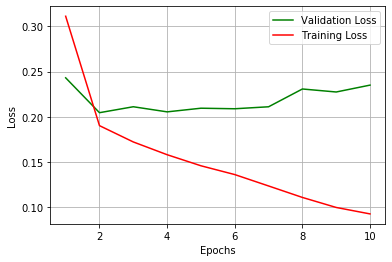

In [19]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

## 2-Layer LSTM model

In [21]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers

embedding_vecor_length = 32

model2 = Sequential()
model2.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(100, return_sequences=True, kernel_initializer = 'random_uniform',W_regularizer=regularizers.l2(0.001)))
model2.add(Dropout(0.5))
model2.add(LSTM(80,W_regularizer=regularizers.l2(0.001)))
model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                57920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Tota

In [22]:
history2=  model2.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 2917s 42ms/step - loss: 0.3060 - acc: 0.8883 - val_loss: 0.2535 - val_acc: 0.8987
Epoch 2/10
70000/70000 [==============================] - 2902s 41ms/step - loss: 0.2212 - acc: 0.9187 - val_loss: 0.2592 - val_acc: 0.9021
Epoch 3/10
70000/70000 [==============================] - 2897s 41ms/step - loss: 0.1985 - acc: 0.9286 - val_loss: 0.5339 - val_acc: 0.7859
Epoch 4/10
70000/70000 [==============================] - 2909s 42ms/step - loss: 0.1872 - acc: 0.9319 - val_loss: 0.2101 - val_acc: 0.9214
Epoch 5/10
70000/70000 [==============================] - 2914s 42ms/step - loss: 0.1745 - acc: 0.9373 - val_loss: 0.3023 - val_acc: 0.9137
Epoch 6/10
70000/70000 [==============================] - 2929s 42ms/step - loss: 0.1730 - acc: 0.9403 - val_loss: 0.2260 - val_acc: 0.9191
Epoch 7/10
70000/70000 [==============================] - 2919s 42ms/step - loss: 0.1598 - acc: 0.9439 - val_l

In [23]:
score= model2.evaluate(X_test, y_test, verbose=0)
print('Test score: ',score[0])
print('Test accuracy: ',score[1])

Test score:  0.22495940328141054
Test accuracy:  0.9256666666666666


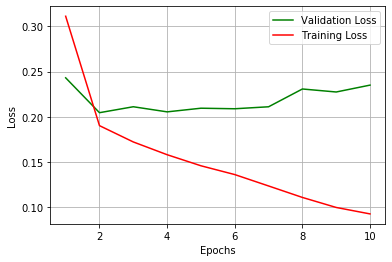

In [24]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

## Conclusion:

In [1]:
from prettytable import PrettyTable
table = PrettyTable()
accuracy=[92.16,92.56]
impl=["Model 1 with 1 LSTM Layer", "Model 2 with 2 LSTM layer and with dropout"]
table.add_column("S.NO",[1,2])
table.add_column("Implementation",impl)
table.add_column(" Accuracy of model",accuracy)
print(table)

+------+--------------------------------------------+--------------------+
| S.NO |               Implementation               |  Accuracy of model |
+------+--------------------------------------------+--------------------+
|  1   |         Model 1 with 1 LSTM Layer          |       92.16        |
|  2   | Model 2 with 2 LSTM layer and with dropout |       92.56        |
+------+--------------------------------------------+--------------------+
